# <center> SIAM CSE Poster: Param Distribution Part

**Requires:**
* `pymc3` for the hierarchical bayes modeling

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as sps
from scipy.integrate import quad

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Generate data from a `double_tent` pdf.

In [2]:
class double_tent:
    ''' double_tent defines a pdf class object on 0,1 with two triangular peaks
        loc: defines the location of two peaks
        weight: defines the height of peaks. Two hieghts must sum to 1.
        Requires: scipy.stats.trapz
    '''
    
    def __init__(self,loc,weight):
        # check that locations and weights are appropriate
        if loc[0]<0 or loc[0]>1:
            raise ValueError('Peaks must be in [0,1]')
        elif loc[1]<0 or loc[1]>1:
            raise ValueError('Peaks must be in [0,1]')
        
        if weight[0]+weight[1]!=1:
            raise ValueError('Weights must sum to 1')
        
        self.loc = loc # defines two peaks of pdf
        self.weight = weight # defines two heights of pdf
        
        # defines pdf function
        self.pdf_fun = lambda x: weight[0]*sps.trapz.pdf(x,loc[0],loc[0],loc=0,scale=0.385)+ \
                        weight[1]*sps.trapz.pdf(x,loc[1],loc[1],loc=0.8,scale=0.2)
    
    
    def pdf(self,x):
        return self.pdf_fun(x)
    
    def rvs(self,N):
        '''Generates N samples from the pdf'''
        # accept reject for sample from f
        sample = np.ones(N)*np.NaN
        i=0 # index for while loop

        while i<N:
            test = np.random.uniform(0,1) # test value

            # acceptance criteria
            if np.random.uniform(0,1)<self.pdf(test)/4:
                sample[i]=test
                i+=1

        return sample
    

In [3]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
start_time = 1
end_time = 3
sigma2 = 1E-3
sigma = np.sqrt(sigma2) # fixed noise level in the data
data_n = 150
sample_size = 800
####

### Generate the Data

We generate data from a double tent function $\lambda$. 

In [4]:
# # define target distribution and noise distribution
# target_alpha = 2
# target_beta = 5

# define the target distribution
lam_dist = double_tent(loc=[0.6,0.2],weight=[0.75,0.25])
noise_dist = sps.norm(0,sigma)

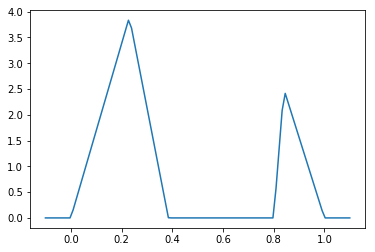

In [5]:
x = np.linspace(-0.1,1.1,100)
plt.plot(x,lam_dist.pdf(x))

The $Q$ map is:

\begin{align}
Q(\lambda,\delta)=0.5\cdot \exp(-\lambda t)+\delta
\end{align}

where we assume $t=0.5$ is constant and $\delta$ is a random variable representing a noise parameter.

In [6]:
# defines the map from parameters to data
def data_map(param,t=np.array([2])):
    q_map = 0.5*np.exp(-t*param)
    noise = noise_dist.rvs(size=q_map.shape)
    q_out = q_map+noise
    return q_out, (q_map,noise)

In [7]:
# gets a sample of lambda for the observed data
lam_sample = lam_dist.rvs(data_n)
data_sample, (this_q,this_noise) = data_map(lam_sample)

(array([ 8., 24., 12.,  0.,  4., 25., 36., 21., 11.,  9.]),
 array([0.01539739, 0.06210243, 0.10880747, 0.15551251, 0.20221755,
        0.24892259, 0.29562763, 0.34233267, 0.38903771, 0.43574275,
        0.48244779]),
 <a list of 10 Patch objects>)

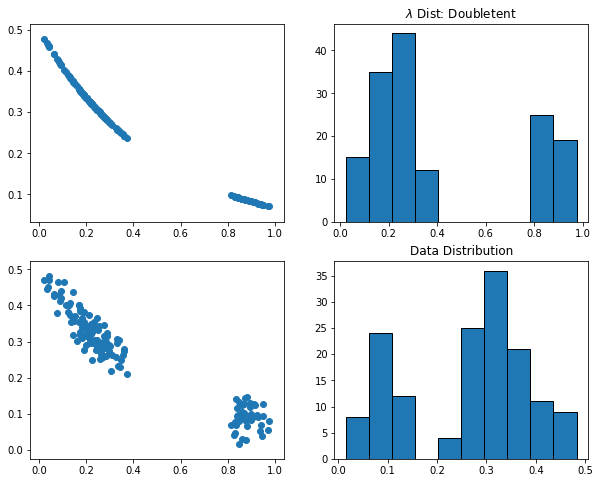

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.scatter(lam_sample,this_q)

ax = fig.add_subplot(2,2,2)
ax.set_title('$\lambda$ Dist: Doubletent')
ax.hist(lam_sample,edgecolor='k')

ax = fig.add_subplot(2,2,3)
ax.scatter(lam_sample,data_sample)

ax = fig.add_subplot(2,2,4)
ax.set_title('Data Distribution')
ax.hist(data_sample,edgecolor='k')

# Infer Using Hierarchical Parameteric Bayes

Here we use the following parametric Bayesian model:

\begin{align}
\alpha,\beta\ &\sim  \chi^2(df=1) \\
\lambda\ \mid\ \alpha,\beta &\sim \text{beta_distr}(\alpha,\beta) \\
d\ \mid \ \lambda, (\alpha,\beta) &\sim N(Q(\lambda),\sigma^2)
\end{align}

which leads to:
\begin{align}
\pi^{post}(\lambda\mid \{d_1,\ldots,d_n\})&\propto \int_{\Omega}\pi^{prior}(\lambda\mid \alpha,\beta)\cdot\pi^{prior}(\alpha,\beta)\cdot \pi^{likelihood}(\{d_1,\ldots,d_n\}\mid \lambda,(\alpha,\beta))\ d\Omega
\end{align}

where $(\alpha,\beta)\in\Omega$ is the $[0,\infty]\times[0,\infty]$.

In [9]:
with pm.Model() as model:
    ab = pm.ChiSquared('hyper',nu=1,shape=(2,))#pm.Uniform('hyper',lower=0,upper=10,shape=(2,))
    lam = pm.Beta('lambda',alpha=ab[0],beta=ab[1], shape=data_n)
    Q_map = pm.Deterministic('Q',0.5*pm.math.exp(-2*lam))
    dat = pm.Normal('data',mu=Q_map,sigma=sigma,observed=data_sample)
    trace = pm.sample(500,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, hyper]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:32<00:00, 123.18draws/s]


In [10]:
# saves the posterior bayes sample as single array
# and computes the posterior-predictive sample
bayes_sample = trace['lambda'].reshape(-1,)
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)
pp_sample = ppc['data'].reshape(-1,)

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1099: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1008.49it/s]


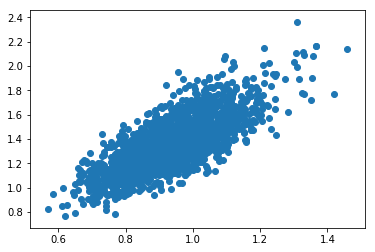

In [11]:
plt.scatter(trace['hyper'][:,0],trace['hyper'][:,1])

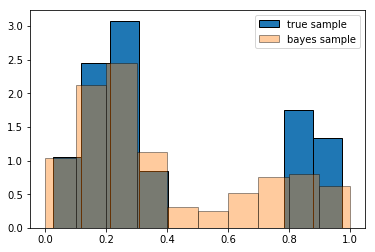

In [12]:
# plots the original target sample versus bayes sample
plt.hist(lam_sample,density=True,edgecolor='k',label='true sample')
plt.hist(bayes_sample,density=True,edgecolor='k',alpha=0.4,label='bayes sample')
plt.legend()

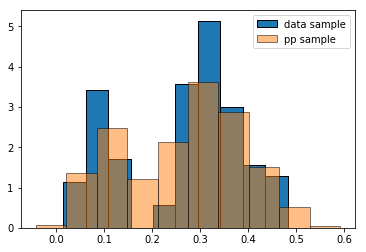

In [13]:
# plots posterior predictive sample vs. data sample
plt.hist(data_sample,density=True,edgecolor='k',label="data sample")
plt.hist(pp_sample,density=True,alpha=0.5,edgecolor='k',label='pp sample')
plt.legend()

# Infer Using Data Consistent Version

Data Consistent model looks like:

\begin{align}
\pi^{init}(\lambda) &\sim U[0,1] \Leftrightarrow \text{beta_distr}(\alpha=1,\beta=1) \\
\pi^{obs}(Q(\lambda)) &\sim \pi(d)\text{, estimated via KDE} \\
\pi^{pf}(Q(\lambda))&\sim \text{can be estimated using samples of lambda, KDE}
\end{align}

The updated distribution will be:
\begin{align}
\pi^{update}(\lambda)&=\pi^{init}(\lambda)\cdot\dfrac{\pi^{obs}(Q(\lambda))}{\pi^{pf}(Q(\lambda))}
\end{align}

In [14]:
# define prior distribution
lam_init = sps.beta(a=1,b=1)

In [15]:
# get prior sample and push-forward sample
lam_init_sample = lam_init.rvs(18000)
pf_init_sample, z = data_map(lam_init_sample)

# estimate the data distribution and push-forward using KDE
data_dist = sps.gaussian_kde(data_sample)
pf_dist = sps.gaussian_kde(pf_init_sample)

In [16]:
# accept-reject algorithm
# calculate maximum of the ratio
M = np.max(data_dist(pf_init_sample)/pf_dist(pf_init_sample))

# generate random numbers from uniform for accept-reject for each sample value
test_value = np.random.uniform(0,1,np.shape(pf_init_sample))

# calculate the ratio for accept reject: data_kde/push_kde/M and compare to test sample
# is the kde ratio > test value?
accept_or_reject_samples = np.greater(data_dist(pf_init_sample)/pf_dist(pf_init_sample)/M,
                            test_value)

# accepted values of posterior sample
updated_sample = lam_init_sample[accept_or_reject_samples]

print('Acceptance Rate about 1/5: update samples = ', np.shape(updated_sample))

Acceptance Rate about 1/5: update samples =  (2195,)


In [17]:
# computes the push-forward of the updated sample
pf_update,_ = data_map(updated_sample)

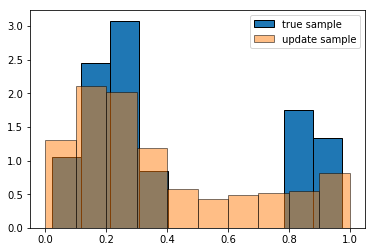

In [18]:
# plots the original target sample versus update sample
plt.figure()
plt.hist(lam_sample,density=True,edgecolor='k',label='true sample')
plt.hist(updated_sample,density=True,edgecolor='k',label='update sample',alpha=0.5)
plt.legend()

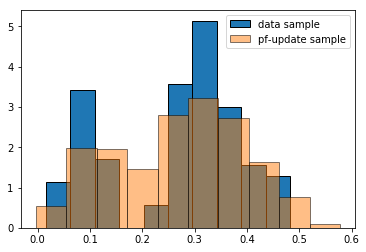

In [19]:
# plots data sample versus push-forward of update sample
plt.hist(data_sample,density=True,edgecolor='k',label="data sample")
plt.hist(pf_update,density=True,alpha=0.5,edgecolor='k',label='pf-update sample')
plt.legend()

# Wrong Bayesian Model

A Bayesian model that is not correct but "looks" more like Data Consistent in terms of form:

\begin{align}
\lambda &\sim \text{beta_distr}(\alpha=1,\beta=1) \ [\text{uniform prior}]\\
d\ \mid \ \lambda &\sim N(Q(\lambda),\sigma^2)
\end{align}

Then the posterior will be:
\begin{align}
\pi^{posterior}(\lambda\mid \{d_1,\ldots,d_n\})\propto \pi^{prior}(\lambda)\cdot \pi^{likelihood}(\{d_1,\ldots,d_n\}\mid \lambda)
\end{align}


In [20]:
with pm.Model() as bad_model:
    lam2 = pm.Beta('lambda',alpha=1,beta=1)
    Q_map2 = pm.Deterministic('Q',0.5*pm.math.exp(-2*lam2))
    dat2 = pm.Normal('data',mu=Q_map2,sigma=sigma,observed=data_sample)
    bad_trace = pm.sample(500,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 700.69draws/s]


In [21]:
# saves the posterior bayes sample as single array
# and computes the posterior-predictive sample
bad_bayes_sample = bad_trace['lambda'].reshape(-1,)
bad_ppc = pm.sample_posterior_predictive(bad_trace, samples=500, model=bad_model)
bad_pp_sample = bad_ppc['data'].reshape(-1,)

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1099: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 920.72it/s]


Mean:  0.3223867968170232
Variance:  0.3223867968170232


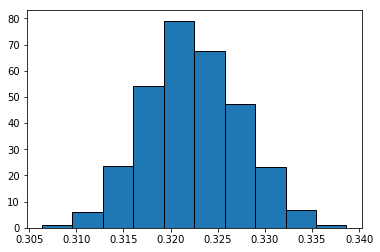

In [22]:
plt.hist(bad_bayes_sample,edgecolor='k',density=True)
print('Mean: ', np.mean(bad_bayes_sample))
print('Variance: ', np.mean(bad_bayes_sample))

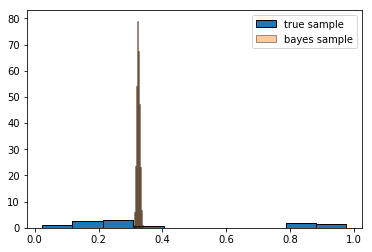

In [23]:
# plots the original target sample versus bayes sample
plt.hist(lam_sample,density=True,edgecolor='k',label='true sample')
plt.hist(bad_bayes_sample,density=True,edgecolor='k',alpha=0.4,label='bayes sample')
plt.legend()

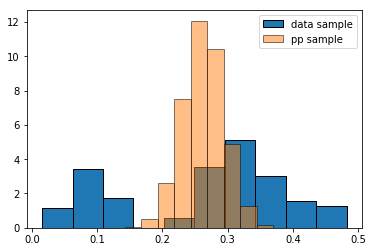

In [24]:
# plots posterior predictive sample vs. data sample
plt.hist(data_sample,density=True,edgecolor='k',label="data sample")
plt.hist(bad_pp_sample,density=True,alpha=0.5,edgecolor='k',label='pp sample')
plt.legend()

# Comparison of Models

In [25]:
import importlib

In [26]:
import seaborn

In [27]:
# get prior sample for plotting hyper prior
hyper_prior_sample = sps.chi2.rvs(df=1,size=(2000,2000))


Text(-0.75, 0.5, '$\\beta$')

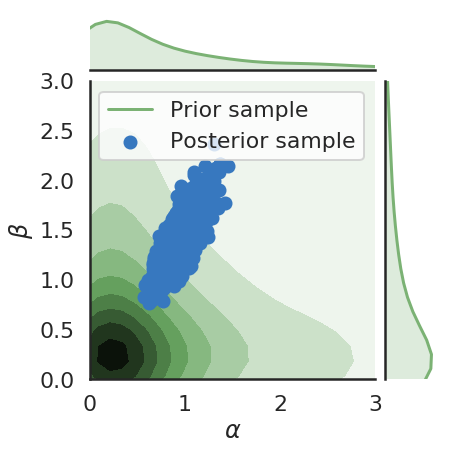

In [28]:
# plot the hyperprior and posterior sample
seaborn.set_style("white")
seaborn.set_context("poster")

# plot hyper prior
hyper_figure = seaborn.jointplot(hyper_prior_sample[0],hyper_prior_sample[1],
                      kind='kde', xlim=(0,3), ylim=(0,3),color='xkcd:faded green')
hyper_figure.ax_joint.plot(0,0,color='xkcd:faded green',label='Prior sample')
# plot the posterior sample
hyper_figure.ax_joint.scatter(trace['hyper'][:,0],trace['hyper'][:,1],
                              color='xkcd:windows blue',label='Posterior sample')
hyper_figure.ax_joint.legend()
hyper_figure.fig.set_figheight(6.5)
hyper_figure.fig.set_figwidth(6.5)
hyper_figure.ax_joint.set_xlabel('$\\alpha$')
hyper_figure.ax_joint.set_ylabel('$\\beta$')

In [29]:
plt.rcParams.update({'font.size': 28,'lines.linewidth':8.5})
# plt.rcParams['figure.figsize'] = 20, 20

In [30]:
# posterior kdes for plotting
posterior_kde=sps.gaussian_kde(bayes_sample)
bad_posterior_kde=sps.gaussian_kde(bad_bayes_sample)
updated_dist = sps.gaussian_kde(updated_sample)

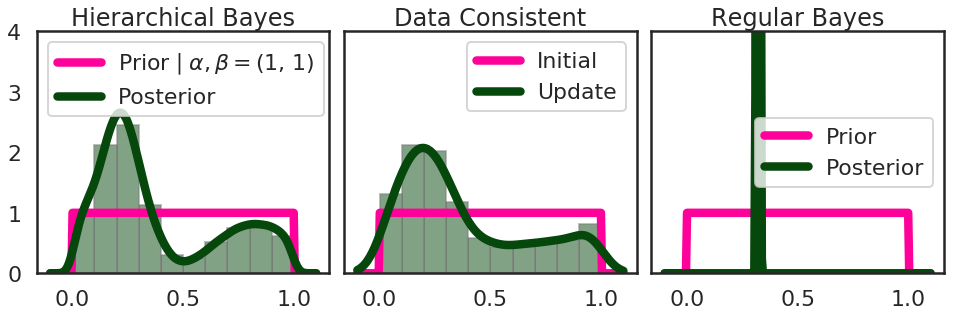

In [37]:
# plot the objects of other spaces
fig_objects,axes = plt.subplots(1,3,sharey=True)
fig_objects.set_figwidth(32/2.54)
fig_objects.set_figheight(fig_objects.get_figwidth()/2.5)



### set other params
# color scheme
# c_prior = 'xkcd:medium green'
# c_post = 'xkcd:windows blue'
c_prior = 'xkcd:neon pink'
c_post = 'xkcd:forest green'

#### plot the parameter space (first row)
x_lam = np.linspace(-0.1,1.1,250)

## HIERARCHICAL BAYES
# prior for hierarchical bayes
ax = axes[0]
# ab_plot = [(0.5,0.5),(1,1),(5,1),(1,3),(2,2)]
# for ab in ab_plot:
#     ax.plot(x_lam,sps.beta.pdf(x_lam,a=ab[0],b=ab[1]),
#                    label='Prior $\\alpha,\\beta = $'+str(ab))

ax.plot(x_lam,sps.beta.pdf(x_lam,a=1,b=1),color=c_prior,
                   label='Prior$\mid \\alpha,\\beta = $'+str((1,1)))

# posterior for hierarchical bayes
ax.hist(bayes_sample,density=True,color=c_post,alpha=0.5,edgecolor='gray')
ax.plot(x_lam,posterior_kde(x_lam),label='Posterior',color=c_post)
ax.legend(loc=2)
ax.set_title('Hierarchical Bayes')


## DATA CONSISTENT
ax = axes[1]
# Initial for Data Consistent
ax.plot(x_lam,lam_init.pdf(x_lam),label='Initial',color=c_prior)

# Update for Data Consistent
ax.hist(updated_sample,density=True,color=c_post,alpha=0.5,edgecolor='gray')
ax.plot(x_lam,updated_dist(x_lam),label='Update',color=c_post)
ax.legend()
ax.set_title('Data Consistent')


## Bad Posterior
ax = axes[2]

# Prior for Bad Bayes
ax.plot(x_lam,lam_init.pdf(x_lam),label='Prior',color=c_prior)

# Posterior for Bad Bayes
ax.hist(bad_bayes_sample,density=True,color=c_post, edgecolor=c_post,alpha=0.7)
ax.plot(x_lam,bad_posterior_kde(x_lam),label='Posterior',color=c_post)
ax.set_ylim(0,4)
ax.legend()
ax.set_title('Regular Bayes')

plt.tight_layout()
plt.subplots_adjust(left=0, right = 1, wspace = 0.05)



In [32]:
# posterior predictive KDEs
pp_kde=sps.gaussian_kde(pp_sample)
bad_pp_kde=sps.gaussian_kde(bad_pp_sample)
pf_update_kde=sps.gaussian_kde(pf_update)
likelihood_pdf = sps.norm(0.5*np.exp(-2*0.5*0.5),sigma)

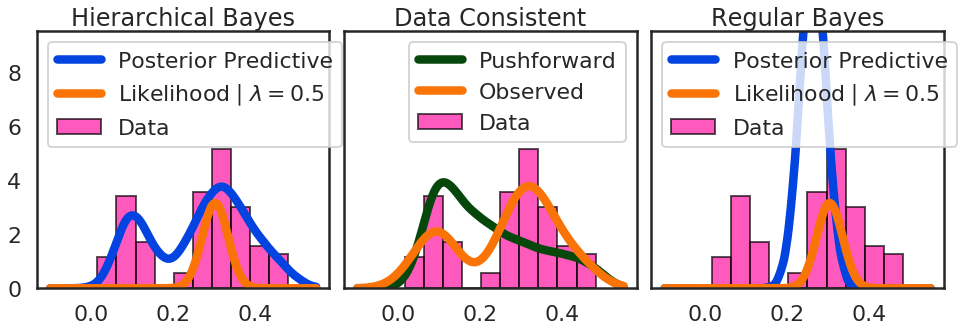

In [33]:
# plot the objects of other spaces
fig_data,axes = plt.subplots(1,3,sharey=True)
fig_data.set_figwidth(32/2.54)
fig_data.set_figheight(fig_objects.get_figwidth()/2.4)


### set other params
# color scheme
# c_data = 'xkcd:dusty purple'
# c_data_use = 'xkcd:amber'
# c_pf = 'xkcd:medium green'
# c_post = 'xkcd:windows blue'
c_data = 'xkcd:neon pink'
c_data_use = 'xkcd:orange'
c_pf = 'xkcd:'
c_post = 'xkcd:blue'


#### plot the parameter space (first row)
x_q = np.linspace(-0.1,0.55,250)

for ax in axes:
    ax.hist(data_sample,density=True,label='Data',color=c_data,
            edgecolor='xkcd:black',alpha=0.65)

## HIERARCHICAL BAYES
# posterior predictive for hierarchical bayes
ax = axes[0]
ax.plot(x_q,pp_kde(x_q),label='Posterior Predictive',color=c_post)
ax.plot(x_q,1/4*likelihood_pdf.pdf(x_q),color=c_data_use,
        label='Likelihood$\mid \\lambda = 0.5$')
ax.legend(loc=2)
ax.set_title('Hierarchical Bayes')


# ## DATA CONSISTENT
ax = axes[1]
# Push-forward and Obeserved
ax.plot(x_q,pf_dist(x_q),label='Pushforward',color=c_pf)
ax.plot(x_q,data_dist(x_q),color=c_data_use,label='Observed')
#ax.plot(x_q,data_dist(x_q),color=c_post, ls=':',alpha=0.5)
ax.legend()
ax.set_title('Data Consistent')

# ## Bad Posterior
ax = axes[2]

# Posterior Predictive
ax.plot(x_q,bad_pp_kde(x_q),label='Posterior Predictive',color=c_post)
ax.plot(x_q,1/4*likelihood_pdf.pdf(x_q),color=c_data_use,
        label='Likelihood$\mid \\lambda = 0.5$')
ax.set_ylim(0,9.5)
ax.legend(loc=2)
ax.set_title('Regular Bayes')

plt.tight_layout()
plt.subplots_adjust(left=0, right = 1, wspace = 0.05)

# right = 0.9   # the right side of the subplots of the figure
# bottom = 0.1  # the bottom of the subplots of the figure
# top = 0.9     # the top of the subplots of the figure
# wspace = 0.2  # the amount of width reserved for space between subplots,
#               # expressed as a fraction of the average axis width
# hspace = 0.2  # the amount of height reserved for space between subplots,
#               # expressed as a fraction of the average axis height
# )


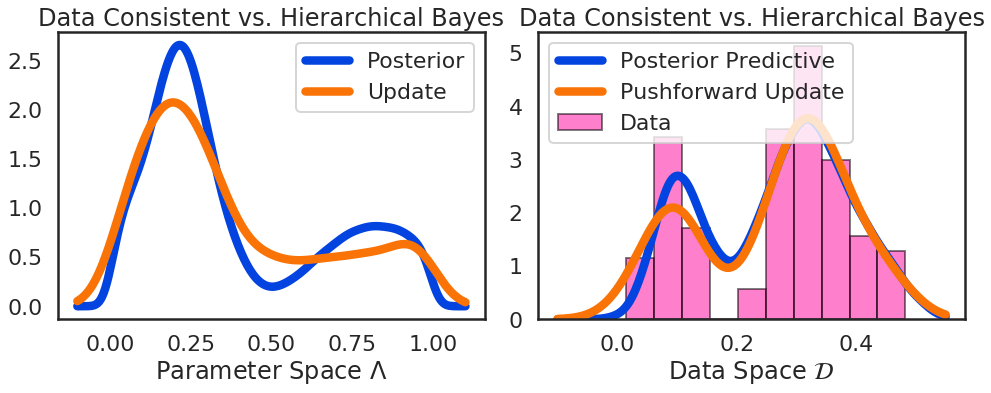

In [34]:
final_fig, axes = plt.subplots(1,2)
final_fig.set_figwidth(32/2.54)
final_fig.set_figheight(15.5/2.54)

bayes_color = 'xkcd:blue'
dci_color = 'xkcd:orange'

# compare in lambda
ax = axes[0]
ax.plot(x_lam,posterior_kde(x_lam),label='Posterior',color=bayes_color)
ax.plot(x_lam,updated_dist(x_lam),label='Update',color=dci_color)
ax.legend()
ax.set_xlabel('Parameter Space $\\Lambda$')
ax.set_title('Data Consistent vs. Hierarchical Bayes')

# compare in data
ax = axes[1]
ax.hist(data_sample,density=True,label='Data',color=c_data,edgecolor='k',alpha=0.5)
ax.plot(x_q,pp_kde(x_q),label='Posterior Predictive',color=bayes_color)
ax.plot(x_q,data_dist(x_q),color=dci_color,label='Pushforward Update')
ax.legend(loc=2)
ax.set_xlabel('Data Space $\mathcal{D}$')
ax.set_title('Data Consistent vs. Hierarchical Bayes')

plt.tight_layout()
plt.subplots_adjust(left=0, right = 1, wspace = 0.125)


In [35]:
# save all figures!
folder = 'figures/'
example = 'distr_EX_'
hyper_figure.savefig(folder+example+'hyper_param.png',bbox_inches = 'tight',pad_inches = 0)
fig_objects.savefig(folder+example+'lambda_space.png',bbox_inches = 'tight',pad_inches = 0)
fig_data.savefig(folder+example+'data_space.png',bbox_inches = 'tight',pad_inches = 0)
final_fig.savefig(folder+example+'comparison.png',bbox_inches = 'tight',pad_inches = 0)